In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Read the data
df = pd.read_csv('customer_segmentation.csv', encoding='utf-8')
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [ ]:
# Print the information
print("Data Types:")
print(df.dtypes)
print("\n")

print("Shape:")
print(df.shape)
print("\n")

print("Null details:")
print(df.isnull().sum())
print("\n")

Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


Shape:
(541909, 8)


Null details:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64




In [ ]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert 'CustomerID' to string
df['CustomerID'] = df['CustomerID'].astype(str)

# Print data types to verify the changes
print("Updated Data Types:")
df.dtypes

Updated Data Types:


,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,object
Country,object


In [ ]:
# Print summary of data
print("Numerical Statistics Summary:")
print(df.describe())
print("\n")

Numerical Statistics Summary:
            Quantity                    InvoiceDate      UnitPrice
count  541909.000000                         541909  541909.000000
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114
min    -80995.000000            2010-12-01 08:26:00  -11062.060000
25%         1.000000            2011-03-28 11:34:00       1.250000
50%         3.000000            2011-07-19 17:17:00       2.080000
75%        10.000000            2011-10-19 11:27:00       4.130000
max     80995.000000            2011-12-09 12:50:00   38970.000000
std       218.081158                            NaN      96.759853




In [ ]:
# Print summary of categorical data
print("Categorical Statistics Summary:")
print(df.describe(include = 'object'))
print("\n")

Categorical Statistics Summary:
       InvoiceNo StockCode                         Description CustomerID  \
count     541909    541909                              540455     541909   
unique     25900      4070                                4223       4373   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER        nan   
freq        1114      2313                                2369     135080   

               Country  
count           541909  
unique              38  
top     United Kingdom  
freq            495478  




Handling missing values, as they are cateogorical and identification type of column it is better to remove than preprocessing it

In [ ]:
# Drop rows with missing values in selected columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
print('Null count:')
print(df.isnull().sum())

Null count:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
# Finding duplicate rows
dp_rows = df[df.duplicated(keep=False)]
dp_rows_sorted = dp_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
dp_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom


In [ ]:
# Dropping duplicate rows from the data
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(535187, 8)

In [ ]:
# removing cancelled transactions to see the proper statistics
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled = df[df['Transaction_Status'] == 'Cancelled']

In [ ]:
df['UnitPrice'].describe()

,UnitPrice
count,535187.000000
mean,4.645242
std,97.364810
min,-11062.060000
25%,1.250000
50%,2.080000
75%,4.130000
max,38970.000000


min Unit price 0 will create data errors so removing them

In [ ]:
# extracting data with unit price > 0 only
df = df[df['UnitPrice'] > 0]

Feature engineering

In [ ]:
# Creating a column 'Days since last purcase'
recent_date = df['InvoiceDate'].max()
recent_date = pd.to_datetime(recent_date)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date

cust_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
cust_data['InvoiceDay'] = pd.to_datetime(cust_data['InvoiceDay'])
cust_data['Days_Since_Last_Purchase'] = (recent_date - cust_data['InvoiceDay']).dt.days

cust_data.drop(columns=['InvoiceDay'], inplace=True)

In [ ]:
cust_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [ ]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

cust_data = pd.merge(cust_data, total_transactions, on='CustomerID')
cust_data = pd.merge(cust_data, total_products_purchased, on='CustomerID')

cust_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2341
3,12349.0,18,1,631
4,12350.0,310,1,197


In [ ]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
avg_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
avg_transaction_value['Average_Transaction_Value'] = avg_transaction_value['Total_Spend'] / avg_transaction_value['Total_Transactions']

cust_data = pd.merge(cust_data, total_spend, on='CustomerID')
cust_data = pd.merge(cust_data, avg_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

cust_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2341,1797.24,449.310000
3,12349.0,18,1,631,1757.55,1757.550000
4,12350.0,310,1,197,334.40,334.400000


In [ ]:
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
cust_data = pd.merge(cust_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
cust_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2341,1797.24,449.310000,22
3,12349.0,18,1,631,1757.55,1757.550000,73
4,12350.0,310,1,197,334.40,334.400000,17


In [ ]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
avg_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
avg_days_between_purchases.rename(columns={'InvoiceDay': 'Avg_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
cust_data = pd.merge(cust_data, avg_days_between_purchases, on='CustomerID')
cust_data = pd.merge(cust_data, favorite_shopping_day, on='CustomerID')
cust_data = pd.merge(cust_data, favorite_shopping_hour, on='CustomerID')

cust_data.head()

<ipython-input-20-fb538c7940ab>:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Avg_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2341,1797.24,449.310000,22,9.433333,3,19
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,0,9
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16


In [ ]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
main_country['Is_UK'] = main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
cust_data = pd.merge(cust_data, main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
cust_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Avg_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2341,1797.24,449.310000,22,9.433333,3,19,0
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,0,9,0
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16,0


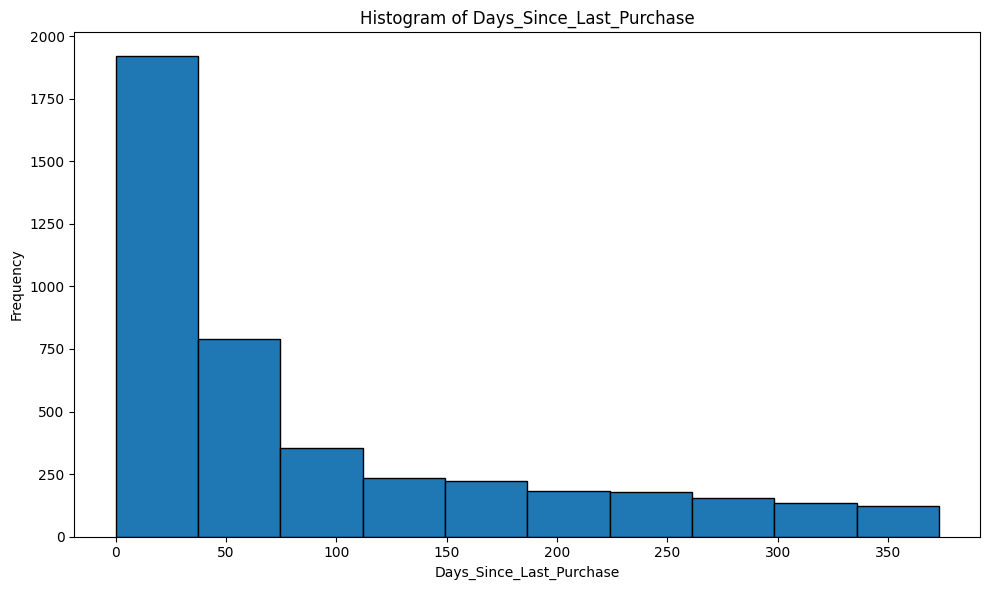

In [ ]:
# Function to create histogram
def create_histogram(df, column):
  """Creates a histogram."""
  plt.figure(figsize=(10, 6))
  plt.hist(df[column], edgecolor='black')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {column}')
  plt.tight_layout()
  plt.show()

create_histogram(cust_data, 'Days_Since_Last_Purchase')

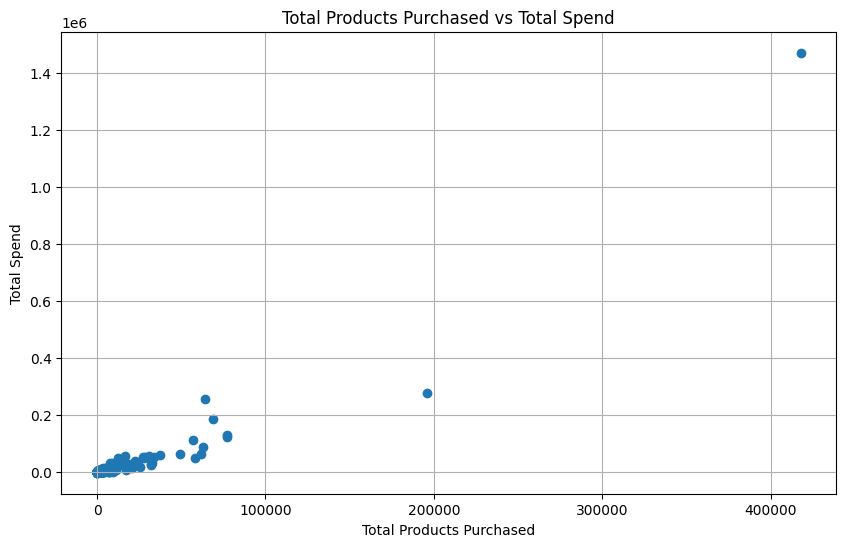

In [ ]:
# Function to create scatter plot
def create_scatter_plot(df, x_col, y_col, title, x_label, y_label):
    """
    Creates a scatter plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

create_scatter_plot(cust_data, 'Total_Products_Purchased', 'Total_Spend', 'Total Products Purchased vs Total Spend', 'Total Products Purchased', 'Total Spend')

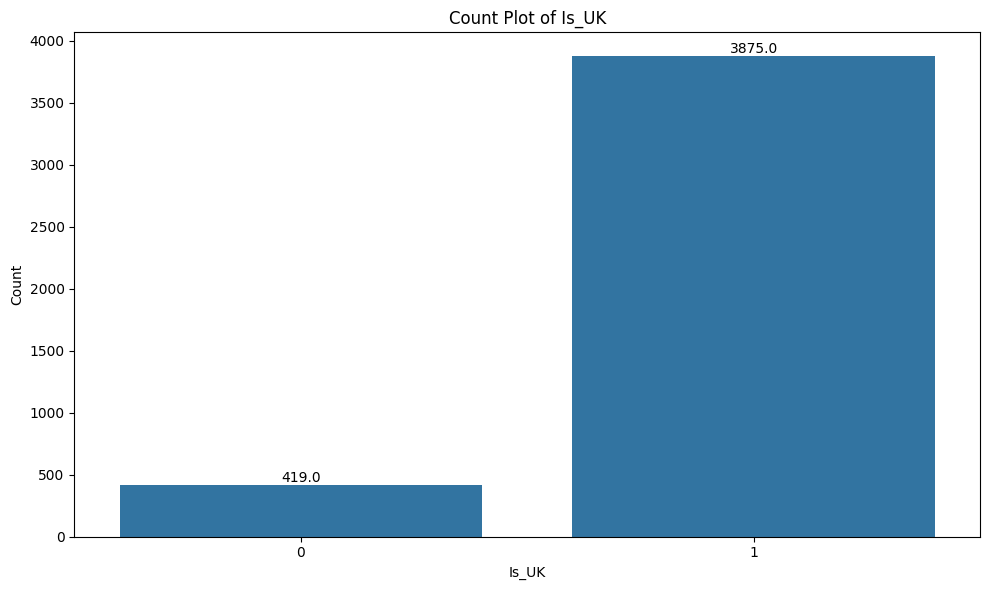

In [ ]:
# Function to create count plot
def create_countplot_with_labels(df, column):
    """
    Creates a count plot with data labels.
    """
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Add data labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

create_countplot_with_labels(cust_data, 'Is_UK')

In [ ]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

cust_data['Outlier_Scores'] = model.fit_predict(cust_data.iloc[:, 1:].to_numpy())

cust_data['Is_Outlier'] = [1 if x == -1 else 0 for x in cust_data['Outlier_Scores']]

cust_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Avg_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1,0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,1,0
2,12348.0,75,4,2341,1797.24,449.310000,22,9.433333,3,19,0,-1,1
3,12349.0,18,1,631,1757.55,1757.550000,73,0.000000,0,9,0,-1,1
4,12350.0,310,1,197,334.40,334.400000,17,0.000000,2,16,0,1,0


In [ ]:
# Separate the outliers for analysis
outliers_data = cust_data[cust_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
cust_data_cleaned = cust_data[cust_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
cust_data_cleaned = cust_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
cust_data_cleaned.reset_index(drop=True, inplace=True)

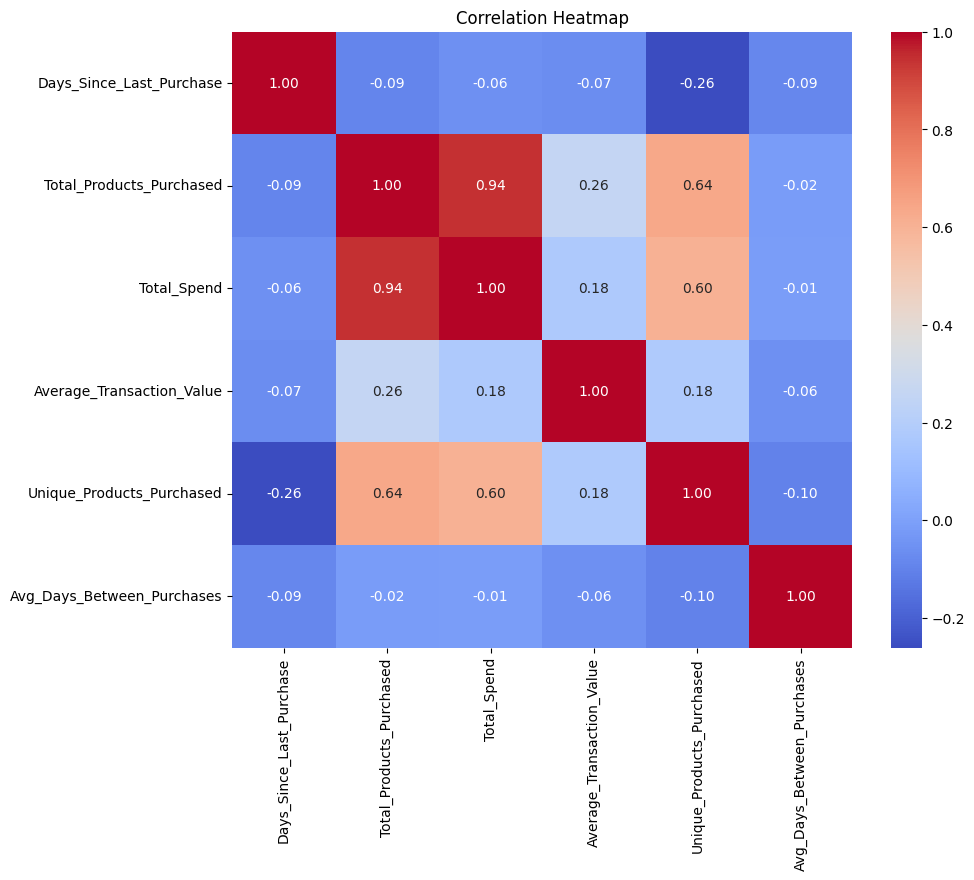

In [ ]:
# Function to create heatmap of correlation
def create_heatmap(df, columns, title):
    """Creates a heatmap of the correlation between specified columns in a DataFrame.
    """
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

create_heatmap(cust_data, ['Days_Since_Last_Purchase', 'Total_Products_Purchased',
                           'Total_Spend', 'Average_Transaction_Value', 'Unique_Products_Purchased',
                           'Avg_Days_Between_Purchases'], 'Correlation Heatmap')

In [ ]:
# Scaling of data
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = cust_data_cleaned.columns.difference(columns_to_exclude)
cust_data_scaled = cust_data_cleaned.copy()
cust_data_scaled[columns_to_scale] = scaler.fit_transform(cust_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
cust_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Avg_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,2.362193,-0.485730,-0.776929,-0.820180,-1.324315,-0.920235,-0.441263,1,-1.086487,1
1,12347.0,-0.902460,0.652682,2.055172,2.302151,1.530858,0.816985,-0.147084,1,0.652489,0
2,12350.0,2.210584,-0.713413,-0.549946,-0.577928,0.226355,-0.647730,-0.441263,2,1.521977,0
3,12352.0,-0.558812,1.563412,-0.235396,0.299374,-0.672830,0.067596,-0.037764,1,0.652489,0
4,12353.0,1.139212,-0.713413,-0.753885,-0.755705,-0.911607,-0.869141,-0.441263,3,1.956721,0


In [ ]:
# Drop ID column
cust_data_scaled = cust_data_scaled.drop(columns=['CustomerID'])
print(cust_data_scaled.head())

   Days_Since_Last_Purchase  Total_Transactions  Total_Products_Purchased  \
0                  2.362193           -0.485730                 -0.776929   
1                 -0.902460            0.652682                  2.055172   
2                  2.210584           -0.713413                 -0.549946   
3                 -0.558812            1.563412                 -0.235396   
4                  1.139212           -0.713413                 -0.753885   

   Total_Spend  Average_Transaction_Value  Unique_Products_Purchased  \
0    -0.820180                  -1.324315                  -0.920235   
1     2.302151                   1.530858                   0.816985   
2    -0.577928                   0.226355                  -0.647730   
3     0.299374                  -0.672830                   0.067596   
4    -0.755705                  -0.911607                  -0.869141   

   Avg_Days_Between_Purchases  Day_Of_Week      Hour  Is_UK  
0                   -0.441263            1

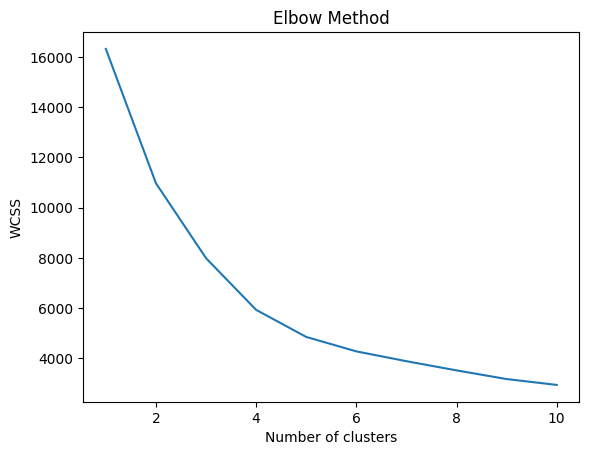

In [ ]:
# Function to create elbow plot using elbow method to find best number of clusters
def create_elbow_plot(df, features):
    """
    Creates an elbow plot to determine the optimal number of clusters.
    """
    X = df[features]
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Calling the function
features_to_use = ['Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Spend', 'Average_Transaction_Value']
create_elbow_plot(cust_data_scaled, features_to_use)

In [ ]:
# Function to perform clutering
def perform_clustering(df, n_clusters):
    """
    Performs KMeans clustering on the given DataFrame.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Cluster'] = kmeans.fit_predict(df)
    return df

n_clusters = 5
cust_data_clustered = perform_clustering(cust_data_scaled, n_clusters)

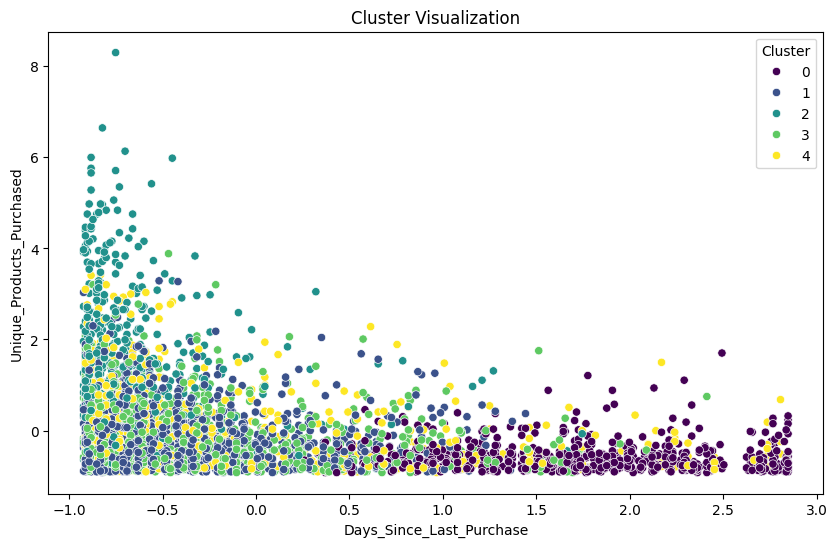

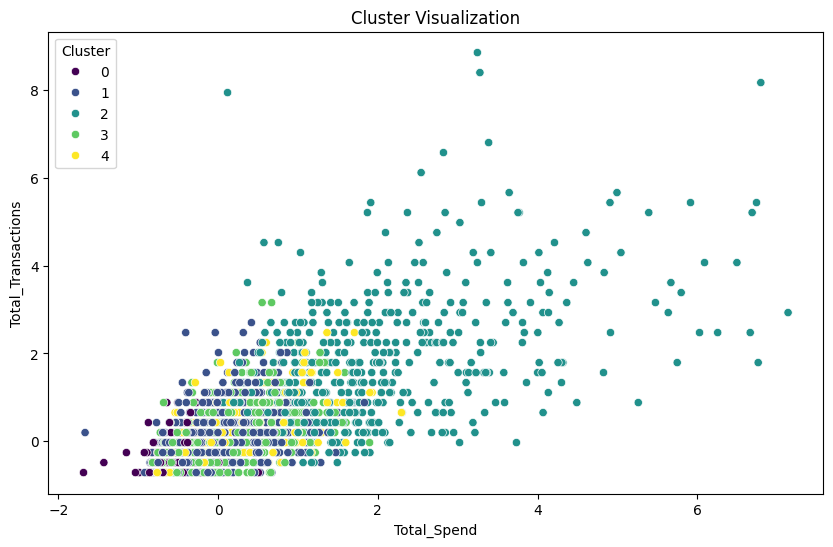

In [ ]:
# Function to create Cluster chart
def create_cluster_scatter_plot(df, features):
    """
    Creates a scatter plot of the clusters.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features[0], y=features[1], hue='Cluster', data=df, palette='viridis')
    plt.title('Cluster Visualization')
    plt.show()

create_cluster_scatter_plot(cust_data_clustered, ['Days_Since_Last_Purchase', 'Unique_Products_Purchased' ])

create_cluster_scatter_plot(cust_data_clustered, ['Total_Spend', 'Total_Transactions'])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test set
X = cust_data_clustered.drop('Cluster', axis=1)
y = cust_data_clustered['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

In [ ]:
# Function to build model and evaluate it
def build_and_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    """Builds a decision tree classifier model and prints its accuracy."""

    clf = DecisionTreeClassifier(random_state=2)

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluate on training data
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Evaluate on testing data
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Decision Tree Test Accuracy: {test_accuracy}")

    return clf, y_train_pred, y_test_pred


# Build and Evaluate the model
clf, y_train_pred, y_test_pred = build_and_evaluate_decision_tree(X_train, X_test, y_train, y_test)

Decision Tree Test Accuracy: 0.9473039215686274


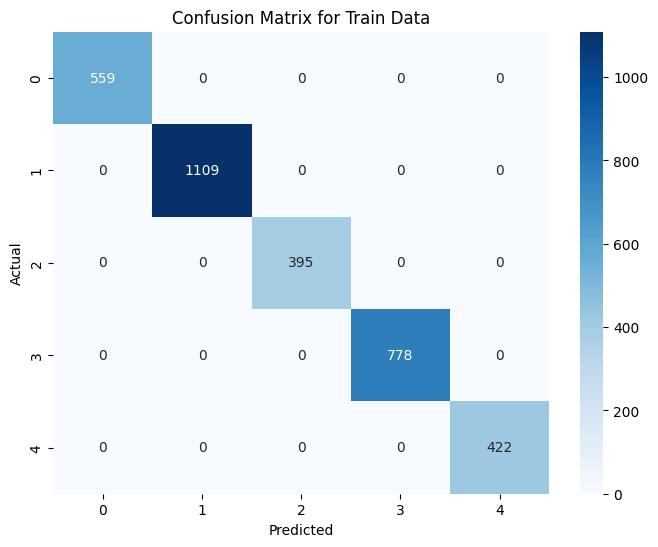

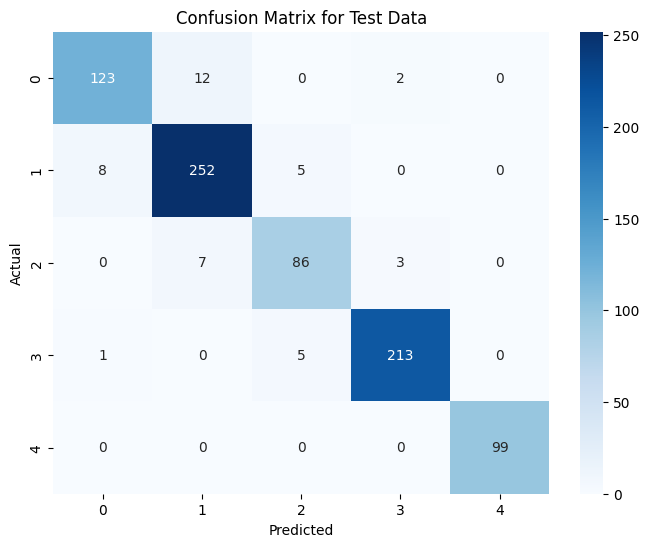

In [ ]:
# Function to create confusion matrix for evaluation
def plot_confusion_matrix(y_true, y_pred, title):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

#Plotting confusion matrix for train data
plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix for Train Data")

#Plotting confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix for Test Data")